<a href="https://colab.research.google.com/github/Remi908/ASP-.Net-API/blob/main/Diffusion_Model_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Smaller Beta Schedule for DDPM
def smaller_beta_schedule(timesteps, start=1e-5, end=2e-3):
    return torch.linspace(start, end, timesteps)

# Forward Diffusion Function
def forward_diffusion(x, t, beta_schedule):
    noise = torch.randn_like(x)
    alpha = torch.cumprod(1 - beta_schedule, dim=0)
    alpha_t = alpha[t].view(-1, 1, 1, 1)  # Adjust dimensions to match input
    x_t = torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * noise
    return x_t, noise

# UNet Backbone for Improved Denoising
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU()
    )

In [13]:
class UNet(nn.Module):
    """
    UNet model with encoder-decoder architecture and skip connections.
    """
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = double_conv(2, 64)       # Input has 2 channels: image + timestep embedding
        self.enc2 = double_conv(64, 128)
        self.enc3 = double_conv(128, 256)

        # Decoder
        self.dec1 = double_conv(256, 128)  # Input: concatenated (upsampled + skip connection)
        self.dec2 = double_conv(128, 64)    # Input: concatenated (upsampled + skip connection)
        self.out = nn.Conv2d(64, 1, kernel_size=1)  # Final output layer

        # Pooling and Upsampling
        self.pool = nn.MaxPool2d(2)
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

    def forward(self, x):
    # Encoding path
        e1 = self.enc1(x)  # Shape: [batch_size, 64, H, W]
        e2 = self.enc2(self.pool(e1))  # Shape: [batch_size, 128, H/2, W/2]
        e3 = self.enc3(self.pool(e2))  # Shape: [batch_size, 256, H/4, W/4]

    # Decoding path with skip connections
        d1 = self.dec1(torch.cat((self.up1(e3), e2), dim=1))  # Shape: [batch_size, 128, H/2, W/2]
        d2 = self.dec2(torch.cat((self.up2(d1), e1), dim=1))  # Shape: [batch_size, 64, H, W]

        return self.out(d2)  # Final output: [batch_size, 1, H, W]



In [3]:
# Denoising Model with Time-Step Embeddings
class DenoisingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.unet = UNet()
        self.timestep_embedding = nn.Embedding(1000, 28 * 28)

    def forward(self, x, t):
        t_embed = self.timestep_embedding(t).view(t.size(0), 1, 28, 28)
        x = torch.cat((x, t_embed), dim=1)  # Concatenate input and time-step embedding
        return self.unet(x)


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.23MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



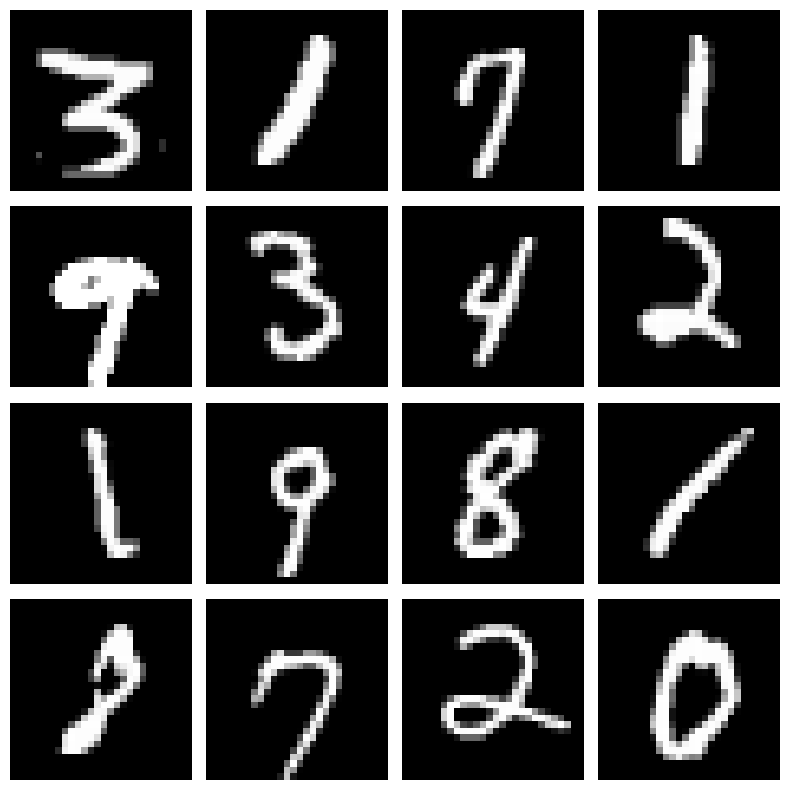

In [4]:
# Data Preprocessing and Visualization
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Visualize the Data
def visualize_data(loader):
    images, labels = next(iter(loader))
    plt.figure(figsize=(8, 8))
    for i in range(16):  # Display 16 images
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i][0].numpy(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_data(train_loader)  # Visualize a batch of training data



In [5]:
# Training Loop
def train_model():
    timesteps = 1000
    beta_schedule = smaller_beta_schedule(timesteps).to(torch.float32)

    model = DenoisingModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.MSELoss()

    num_epochs = 1
    for epoch in range(num_epochs):
        epoch_loss = 0
        model.train()   # Set the model to training mode
        for x, _ in train_loader:
            # Generate random timesteps
            t = torch.randint(0, timesteps, (x.size(0),), dtype=torch.long)

            # Apply forward diffusion to the input
            x_t, noise = forward_diffusion(x, t, beta_schedule)

            # Predict the noise using the model
            pred_noise = model(x_t, t)

            # Compute the loss
            loss = loss_fn(pred_noise, noise)

            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate epoch loss
            epoch_loss += loss.item()

        # Display epoch loss
        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

In [6]:
def sample(model, shape, timesteps, beta_schedule):
    """
    Generates samples by reverse diffusion.

    Args:
        model (nn.Module): Trained denoising model.
        shape (tuple): Shape of the output tensor (batch_size, channels, height, width).
        timesteps (int): Total number of timesteps.
        beta_schedule (torch.Tensor): Predefined beta schedule.

    Returns:
        torch.Tensor: Generated samples (denoised images).
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        x = torch.randn(shape)  # Start with random noise
        alpha = torch.cumprod(1 - beta_schedule, dim=0)

        for t in reversed(range(timesteps)):
            beta_t = beta_schedule[t]
            alpha_t = alpha[t]

            timestep_tensor = torch.full((shape[0],), t, dtype=torch.long)  # Batch of timesteps
            pred_noise = model(x, timestep_tensor)  # Predict the noise
            x = (x - torch.sqrt(1 - alpha_t) * pred_noise) / torch.sqrt(alpha_t)

            if t > 0:  # Add noise unless it's the last step
                noise = torch.randn_like(x)
                x += torch.sqrt(beta_t) * noise
    return x  # Final denoised image


In [12]:
print("Starting training...")
train_model()

Starting training...


RuntimeError: Given groups=1, weight of size [128, 384, 3, 3], expected input[64, 256, 14, 14] to have 384 channels, but got 256 channels instead

Visualizing the diffusion process...


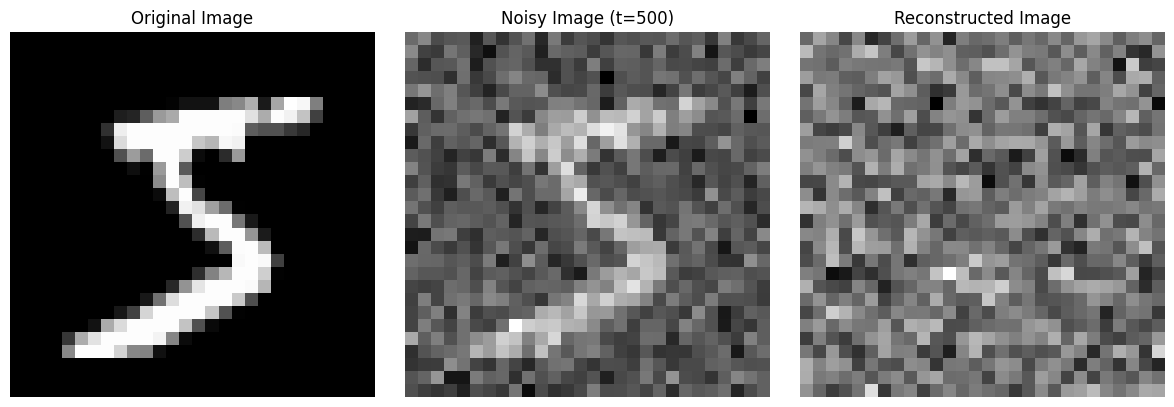

In [8]:
# Function to visualize original, noisy, and reconstructed images
def visualize_diffusion_process(model, train_dataset, beta_schedule, timesteps=1000):
    """
    Visualizes the diffusion process:
    1. Original image from the dataset.
    2. Noisy version of the image at a selected timestep.
    3. Reconstructed image after reverse diffusion.

    Args:
        model (nn.Module): Trained denoising model.
        train_dataset (Dataset): Training dataset.
        beta_schedule (torch.Tensor): Predefined beta schedule.
        timesteps (int): Total number of timesteps.
    """
    # Pick a random image from the dataset
    sample_image, _ = train_dataset[0]  # Get the first image (ignore the label)
    sample_image = sample_image.unsqueeze(0)  # Add batch dimension

    # Apply forward diffusion
    t = timesteps // 2  # Pick a midpoint timestep
    x_t, noise = forward_diffusion(sample_image, torch.tensor([t]), beta_schedule)

    # Apply reverse diffusion
    reconstructed_image = sample(model, shape=x_t.shape, timesteps=t, beta_schedule=beta_schedule)

    # Visualize original, noisy, and reconstructed images
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(sample_image[0, 0].cpu().numpy(), cmap='gray')
    plt.axis('off')

    # Noisy Image
    plt.subplot(1, 3, 2)
    plt.title(f"Noisy Image (t={t})")
    plt.imshow(x_t[0, 0].cpu().numpy(), cmap='gray')
    plt.axis('off')

    # Reconstructed Image
    plt.subplot(1, 3, 3)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed_image[0, 0].cpu().numpy(), cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Example Usage
if __name__ == "__main__":
    # Define hyperparameters and initialize beta schedule
    timesteps = 1000
    beta_schedule = smaller_beta_schedule(timesteps).to(torch.float32)

    # Ensure the model is loaded (trained or pre-trained)
    model = DenoisingModel()

    # Visualize diffusion process
    print("Visualizing the diffusion process...")
    visualize_diffusion_process(model, train_dataset, beta_schedule, timesteps=timesteps)
